In [34]:
import sqlite3
import enum
from functools import total_ordering

FIG_PATH = "/home/tim/Projects/bachelor-thesis/figs/"
DB_PATH = "/home/tim/idintfw.db"

con = sqlite3.connect(DB_PATH)
c = con.cursor()
rows = c.execute("SELECT * FROM Runs LEFT JOIN Errors ON Runs.ID=Errors.Run")

class App:
    def __init__(self, name, sources, sinks, classes, methods, statements, cgsize):
        self.name = name
        self.sources = sources
        self.sinks = sinks
        self.classes=classes
        self.methods=methods
        self.statements=statements
        self.cgsize=cgsize
        self.runs = []
        self.smpRuns = []
        self.fwRuns = []
        self.bwRuns = []
        self.fwsmpRuns = []
        self.bwsmpRuns = []
        
    def addRun(self, run):
        if run.direction == Direction.Forwards:
            self.fwRuns.append(run)
        elif run.direction == Direction.Backwards:
            self.bwRuns.append(run)
        elif run.direction == Direction.ForwardsSMP:
            self.fwsmpRuns.append(run)
        elif run.direction == Direction.BackwardsSMP:
            self.bwsmpRuns.append(run)
    
    def isTimeValid(self):
        return len(self.runs) == 2
    def isMemValid(self):
        return len(self.smpRuns) == 2
            
    def _timeMedian(self, src, dst):
        if 0 < len(src) < 3:
            print("ERROR: Only %s time-runs for %s!" % (len(src), self.name))

        if len(src) != 3:
            return
        
        src.sort()
        if src[1].dataflowTime != 0:
            relDiff = abs(src[0].dataflowTime - src[1].dataflowTime) / abs(src[1].dataflowTime)
            absDiff = src[1].dataflowTime-src[0].dataflowTime
            if relDiff > 0.5 and absDiff > 5:
                print("FML0 %s for %s" % (src[0].ID, src[0].runID))
            relDiff = (src[2].dataflowTime - src[1].dataflowTime) / abs(src[1].dataflowTime)
            absDiff = src[2].dataflowTime-src[1].dataflowTime
            if relDiff > 0.5 and absDiff > 5:
                print("FML2 %s for %s" % (src[2].ID, src[2].runID))
        dst.append(src[1])
        src.clear()
        
    def _memMedian(self, src, dst):
        if 0 < len(src) < 3:
            print("ERROR: Only %s mem-runs for %s!" % (len(src), self.name))

        if len(src) != 3:
            return
        
        src.sort(key=lambda x: x.maxMemPrecise)
        if src[1].maxMemPrecise != 0:
            relDiff = abs(src[0].maxMemPrecise - src[1].maxMemPrecise) / abs(src[1].maxMemPrecise)
            if relDiff > 0.75:
                print("MEMFML0 %s for %s" % (src[0].ID, src[0].runID))
            relDiff = (src[2].maxMemPrecise - src[1].maxMemPrecise) / abs(src[1].maxMemPrecise)
            if abs(relDiff) > 0.75:
                print("MEMFML2 %s for %s" % (src[2].ID, src[2].runID))
        dst.append(src[1])
        src.clear()
    
    def selectMedian(self):
        self._timeMedian(self.fwRuns, self.runs)
        self._timeMedian(self.bwRuns, self.runs)
        self._memMedian(self.fwsmpRuns, self.smpRuns)
        self._memMedian(self.bwsmpRuns, self.smpRuns)
        

class Direction(enum.Enum):
    Forwards = 0
    Backwards = 1
    ForwardsSMP = 2
    BackwardsSMP = 3
    
@total_ordering
class TimeRun:
    def __init__(self, ID, direction, maxMem, infoflowEdges, aliasEdges, timeElapsed, dataflowTime, 
                 leaks, terminationState, absCountInfoflow, absCountAlias, runID, avgMemInfo, avgMemAlias,
                 finalMemInfo, finalMemAlias):
        if direction == "FastSolverfw":
            self.direction = Direction.Forwards
        elif direction == "FastSolverbw":
            self.direction = Direction.Backwards
        elif direction == "FastSolverfw_smp":
            self.direction = Direction.ForwardsSMP
        elif direction == "FastSolverbw_smp":
            self.direction = Direction.BackwardsSMP
        else:
            print("ERROR: Unknown direction!")
        self.ID = ID
        self.maxMem = maxMem
        self.infoflowEdges = infoflowEdges
        self.aliasEdges = aliasEdges
        self.timeElapsed = timeElapsed
        self.dataflowTime = dataflowTime
        self.leaks = leaks
        self.absCountInfoflow = absCountInfoflow
        self.absCountAlias = absCountAlias
        self.memoryTimeout = terminationState == 2 
        self.timeTimeout = terminationState == 1 and dataflowTime > 599
        self.runID = runID
        self.avgMemInfo = avgMemInfo
        self.avgMemAlias = avgMemAlias
        self.avgMem = (self.avgMemInfo + self.avgMemAlias) / 2.0
        self.finalMemInfo = finalMemInfo
        self.finalMemAlias = finalMemAlias
        self.maxMemPrecise = self.finalMemInfo + self.finalMemAlias
        
    def __lt__(self, other):
        return self.dataflowTime < other.dataflowTime

        
apps = {}
for row in rows:
    name = row[1]
    
    if not name in apps:
        apps[name] = App(name, row[16], row[17], row[18], row[19], row[20], row[21])

    # no need to add Runs which
    # did not start
    # had no sinks, thus -1 time
    # with exception thrown
    if row[6] == None or row[6] == -1 or row[26] != None or row[10] == 0:
        continue
    # only verify source sink manager when analysis started
    app = apps[name]
    if row[16] != app.sources:
        # print("Sources differ for %s: %s to %s" % (name, app.sources, row[16]))
        continue
    if row[17] != app.sinks:
        # print("Sinks differ for %s: %s to %s" % (name, app.sinks, row[17]))
        continue

    # ignore run 0
    if row[25] > 0:
        app.addRun(TimeRun(row[0], row[2], row[7], row[22], row[23], row[5], row[6], row[14], 
                           row[15], row[12], row[13], row[25], row[8], row[9], row[10], row[11]))
    
for app in apps.values():
    app.selectMedian()

def runToColor(run):
    if run.memoryTimeout:
        return "#d62728"
    elif run.timeTimeout:
        return "#ff7f0e"
    else:
        return "#1f77b4"
    
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pylatex.utils import escape_latex 

matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    "pgf.preamble": [
        r'\usepackage{amsmath}'
    ],
    'font.family': 'sans-serif',
    'font.sans-serif': ['Roboto'],
    'text.usetex': True,
    'pgf.rcfonts': False,
})


MEMFML2 2097 for 3
MEMFML2 1714 for 1
MEMFML0 2328 for 1
MEMFML0 1776 for 1
MEMFML0 1856 for 1
ERROR: Only 1 time-runs for com.labs.merlinbirdid.app.apk!
FML0 3096 for 3
FML2 3082 for 1
MEMFML0 2790 for 3


-111.19847328244275
131


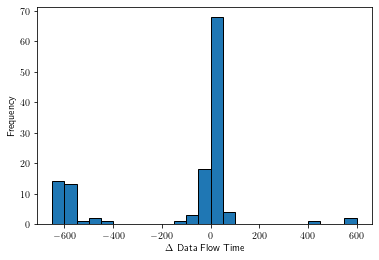

In [23]:
# Delta of each app

xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []

delta = []
for name, app in apps.items():
    if not app.isTimeValid():
        continue
        
    leaks = -1
    d = 0
       
    r1 = None
    r2 = None
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw.append(escape_latex(name))
            cfw.append(runToColor(run))
            d -= run.dataflowTime
            r1 = run
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw.append(escape_latex(name))
            cbw.append(runToColor(run))
            d += run.dataflowTime
            r2 = run
#         if leaks == -1:
#             leaks = run.leaks
#         elif leaks != run.leaks:
#             print(f"Leaks differ for {name}: {leaks} vs {run.leaks}")
            
    if abs(d) > 399:
        rel = app.sources / app.sinks
        if d < 0:
            ed1 = round(r1.infoflowEdges / r2.infoflowEdges)
            ed2 = round(r1.aliasEdges / r2.aliasEdges)
        else:
            ed1 = round(r2.infoflowEdges / (1 if r1.infoflowEdges == 0 else r1.infoflowEdges))
            ed2 = round(r2.aliasEdges / (1 if r1.aliasEdges == 0 else r1.aliasEdges))
#         print(f"{name}: {d}s with {app.sources}:{app.sinks} and edge {ed1}:{ed2}")
    delta.append(d)

        
print(sum(delta)/len(xfw))
print(len(xfw))

fig = plt.figure()
base = 50
rounded = int(base * np.ceil(np.abs(delta).max()/base))
plt.hist(delta, bins=np.arange(-rounded, rounded, base), edgecolor='black')
plt.xlabel("$\\Delta$ Data Flow Time")
plt.ylabel("Frequency")
plt.savefig(FIG_PATH + "deltaHist.pgf")

# fig = plt.figure(figsize=(20, 5))
# ax = fig.add_subplot(111)
# ind = np.arange(len(xfw))
# width = 0.2
# ax.bar(ind, delta, width)
# ax.bar(ind - width/2, datafw, width, color=cfw)
# ax.bar(ind + width/2, databw, width, color=cbw)
# ax.set_xticklabels(xfw)
# plt.xticks(ind)
# ax.set_ylabel("$\\Delta$ Dataflow Time")
# _ = plt.xticks(rotation=90)
# plt.savefig(FIG_PATH + "dataflowDelta.pgf")

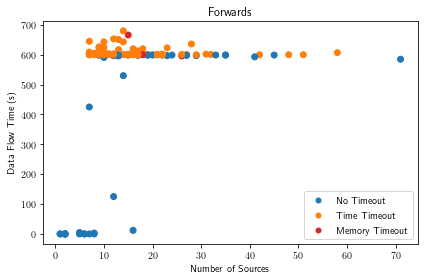

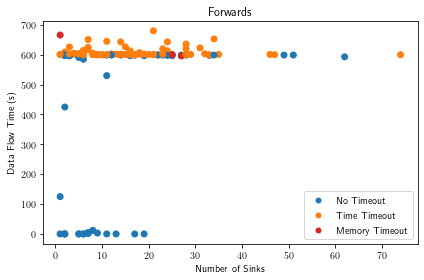

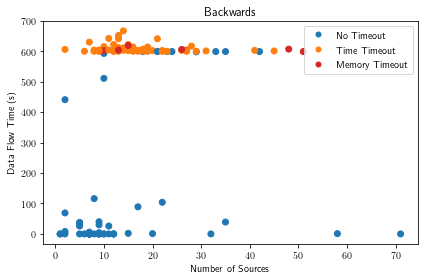

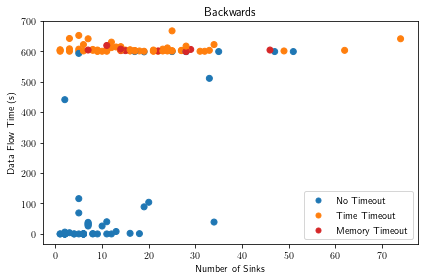

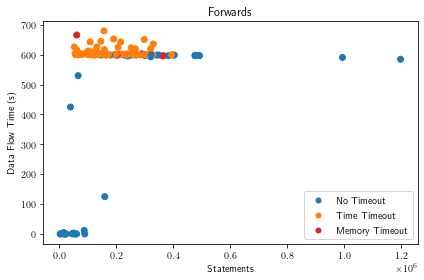

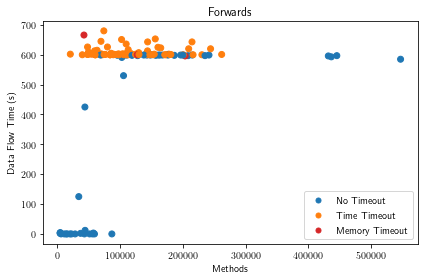

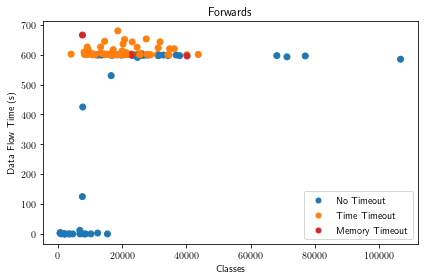

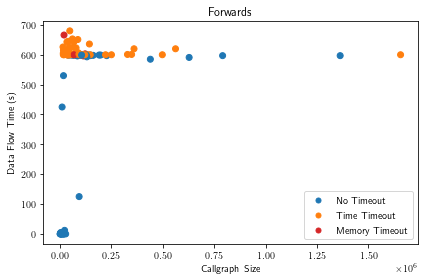

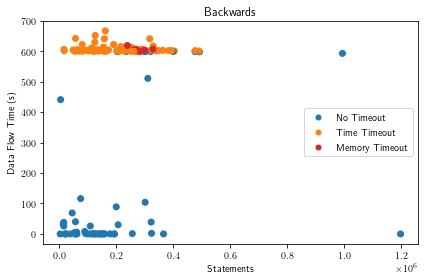

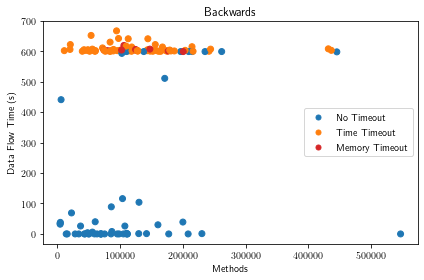

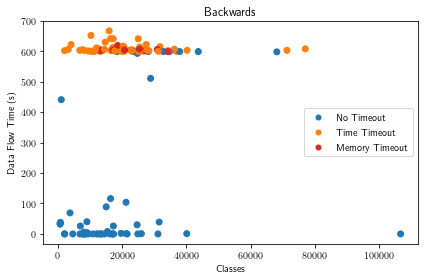

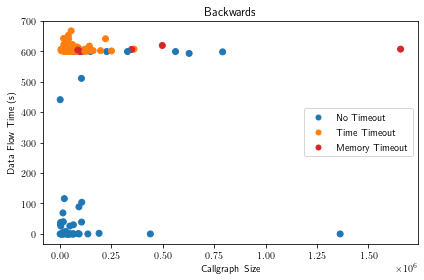

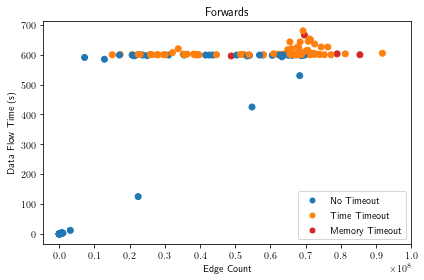

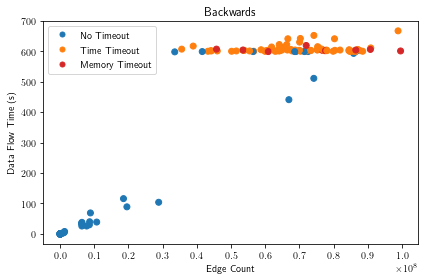

In [38]:
# Per Sources/Sinks
blue_dot = mlines.Line2D([], [], color='#1f77b4', marker='.', linestyle='None',
                          markersize=10, label='No Timeout')
orange_dot = mlines.Line2D([], [], color='#ff7f0e', marker='.', linestyle='None',
                          markersize=10, label='Time Timeout')
red_dot = mlines.Line2D([], [], color='#d62728', marker='.', linestyle='None',
                          markersize=10, label='Memory Timeout')
handles = [blue_dot, orange_dot, red_dot]

xsources = []
xsinks = []
xstmts = []
xclasses = []
xmethods = []
xcg = []
xedgesfw = []
xedgesbw = []
xpropfw = []
xpropbw = []
datafw = []
cfw = []
databw = []
cbw = []
for name, app in apps.items():
    if not app.isTimeValid():
        continue
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xsources.append(app.sources)
            xsinks.append(app.sinks)
            xstmts.append(app.statements)
            xclasses.append(app.classes)
            xmethods.append(app.methods)
            xcg.append(app.cgsize)
            xedgesfw.append(run.absCountInfoflow + run.absCountAlias)
            cfw.append(runToColor(run))
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            cbw.append(runToColor(run))
            xedgesbw.append(run.absCountInfoflow + run.absCountAlias)



plt.figure()
plt.scatter(xsources, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-sources.pgf")       
plt.figure()
plt.scatter(xsinks, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-sinks.pgf")

plt.figure()
plt.scatter(xsources, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-sources.pgf")
plt.figure()
plt.scatter(xsinks, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-sinks.pgf")

plt.figure()
plt.scatter(xstmts, datafw, c=cfw)
plt.xlabel("Statements")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-statements.pgf")
plt.figure()
plt.scatter(xmethods, datafw, c=cfw)
plt.xlabel("Methods")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-methods.pgf")
plt.figure()
plt.scatter(xclasses, datafw, c=cfw)
plt.xlabel("Classes")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-classes.pgf")
plt.figure()
plt.scatter(xcg, datafw, c=cfw)
plt.xlabel("Callgraph Size")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-cg.pgf")
plt.figure()
plt.scatter(xstmts, databw, c=cbw)
plt.xlabel("Statements")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-statements.pgf")
plt.figure()
plt.scatter(xmethods, databw, c=cbw)
plt.xlabel("Methods")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-methods.pgf")
plt.figure()
plt.scatter(xclasses, databw, c=cbw)
plt.xlabel("Classes")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-classes.pgf")
plt.figure()
plt.scatter(xcg, databw, c=cbw)
plt.xlabel("Callgraph Size")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-cg.pgf")

edgeMax = max(np.max(xedgesfw), np.max(xedgesbw))
scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
plt.scatter(xedgesfw, datafw, c=cfw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_dataflow-edges.pgf")

plt.figure()
plt.scatter(xedgesbw, databw, c=cbw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Data Flow Time (s)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_dataflow-edges.pgf")

In [37]:
datafw = []
datafw2 = []
memfw = []
memfw2 = []
iabsfw = []
iabsfw2 = []
aabsfw = []
aabsfw2 = []
tofw = [0, 0, 0]

databw = []
databw2 = []
membw = []
membw2 = []
iabsbw = []
iabsbw2 = []
aabsbw = []
aabsbw2 = []
tobw = [0, 0, 0]

for name, app in apps.items():
    if not app.isTimeValid:
        continue
    
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            memfw.append(run.maxMem)
            iabsfw.append(run.absCountInfoflow)
            aabsfw.append(run.absCountAlias)
            if run.memoryTimeout:
                tofw[2] += 1
            elif run.timeTimeout:
                tofw[1] += 1
            else:
                tofw[0] += 1
                datafw2.append(run.dataflowTime)
                memfw2.append(run.maxMem)
                iabsfw2.append(run.absCountInfoflow)
                aabsfw2.append(run.absCountAlias)
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            membw.append(run.maxMem)
            iabsbw.append(run.absCountInfoflow)
            aabsbw.append(run.absCountAlias)
            if run.memoryTimeout:
                tobw[2] += 1
            elif run.timeTimeout:
                tobw[1] += 1
            else:
                tobw[0] += 1
                databw2.append(run.dataflowTime)
                membw2.append(run.maxMem)
                iabsbw2.append(run.absCountInfoflow)
                aabsbw2.append(run.absCountAlias)
                
# print(f"DFlow/Abs {sum(datafw) / (sum(iabsfw)+sum(aabsfw))} & {sum(databw) / (sum(iabsbw2)+sum(aabsbw))}")
            
percentile = 85
print(f"Average Runtime & ${round(sum(datafw) / sum(tofw),2)}s$ & ${round(sum(databw) / sum(tobw),2)}s$\\\\")
print(f"Median Runtime & ${np.median(datafw)}s$ & ${np.median(databw)}s$\\\\")
print(f"{percentile}\\textsuperscript{{th}} Percentile & ${round(np.percentile(datafw, percentile), 2)}s$ & ${round(np.percentile(databw, percentile), 2)}s$\\\\")
print("\\hline")
print(f"Average Abstractions Infoflow & ${round(sum(iabsfw)/sum(tofw))}$ & ${round(sum(iabsbw)/sum(tobw))}$\\\\")
print(f"Average Abstractions Alias & ${round(sum(aabsfw)/sum(tofw))}$ & ${round(sum(aabsbw)/sum(tobw))}$\\\\")
print(f"Average Total Abstractions & ${round(sum(iabsfw)/sum(tofw))+round(sum(aabsfw)/sum(tofw))}$ & ${round(sum(iabsbw)/sum(tobw))+round(sum(aabsbw)/sum(tobw))}$\\\\")
print("\\hline")
# print(f"Average Max Memory Consumption & ${round(sum(memfw) / sum(tofw), 2)} GB$ & ${round(sum(membw) / sum(tobw), 2)} GB$\\\\")
# print("\\hline")
print(f"Memory Timeouts & ${round((tofw[2] / sum(tofw) * 100), 2)}\\%$ & ${round((tobw[2] / sum(tobw) * 100), 2)}\\%$\\\\")
print(f"Time Timeouts & ${round((tofw[1] / sum(tofw) * 100), 2)}\\%$ & ${round((tobw[1] / sum(tobw) * 100), 2)}\\%$\\\\")
print()
print(f"Average Runtime & ${round(sum(datafw2) / tofw[0],2)}s$ & ${round(sum(databw2) / tobw[0],2)}s$\\\\")
print(f"Median Runtime & ${np.median(datafw2)}s$ & ${np.median(databw2)}s$\\\\")
print(f"{percentile}\\textsuperscript{{th}} Percentile & ${round(np.percentile(datafw2, percentile), 2)}s$ & ${round(np.percentile(databw2, percentile), 2)}s$\\\\")
print("\\hline")
print(f"Average Abstractions Infoflow & ${round(sum(iabsfw2)/sum(tofw))}$ & ${round(sum(iabsbw2)/sum(tobw))}$\\\\")
print(f"Average Abstractions Alias & ${round(sum(aabsfw2)/sum(tofw))}$ & ${round(sum(aabsbw2)/sum(tobw))}$\\\\")
print(f"Average Total Abstractions & ${round(sum(iabsfw2)/sum(tofw))+round(sum(aabsfw2)/sum(tofw))}$ & ${round(sum(iabsbw2)/sum(tobw))+round(sum(aabsbw2)/sum(tobw))}$\\\\")
# print("\\hline")
# print(f"Average Max Memory Consumption & ${round(sum(memfw2) / tofw[0], 2)} GB$ & ${round(sum(membw2) / tobw[0], 2)} GB$\\\\")

Average Runtime & $518.93s$ & $408.97s$\\
Median Runtime & $600.0s$ & $600.0s$\\
85\textsuperscript{th} Percentile & $605.1s$ & $606.2s$\\
\hline
Average Abstractions Infoflow & $34555327$ & $13702123$\\
Average Abstractions Alias & $12562479$ & $33447121$\\
Average Total Abstractions & $47117806$ & $47149244$\\
\hline
Memory Timeouts & $2.99\%$ & $6.77\%$\\
Time Timeouts & $60.45\%$ & $51.88\%$\\

Average Runtime & $364.0s$ & $127.33s$\\
Median Runtime & $596.0s$ & $1.0s$\\
85\textsuperscript{th} Percentile & $599.0s$ & $584.8s$\\
\hline
Average Abstractions Infoflow & $7744724$ & $2048023$\\
Average Abstractions Alias & $2784113$ & $4480848$\\
Average Total Abstractions & $10528837$ & $6528871$\\


In [26]:
avgMaxMemfw = []
avgMaxMembw = []
avgMaxMemWOfw = []
avgMaxMemWObw = []
memPerAbsfw = []
memPerAbsbw = []
memPerAbsWOfw = []
memPerAbsWObw = []

for name, app in apps.items():
    if not app.isMemValid():
        continue

    fw = -1
    fwAbs = -1
    bw = -1
    bwAbs = -1
    timeout = False
    for run in app.smpRuns:
        if run.direction == Direction.ForwardsSMP:
            fw = run.maxMemPrecise
            fwAbs = run.absCountInfoflow + run.absCountAlias
            timeout = timeout or run.timeTimeout
        elif run.direction == Direction.BackwardsSMP:
            bw = run.maxMemPrecise
            bwAbs = run.absCountInfoflow + run.absCountAlias
            timeout = timeout or run.timeTimeout

    avgMaxMemfw.append(fw)
    avgMaxMembw.append(bw)
    memPerAbsfw.append(fw / fwAbs)
    memPerAbsbw.append(bw / bwAbs)
    if not timeout:
        avgMaxMemWOfw.append(fw)
        avgMaxMemWObw.append(bw)
        memPerAbsWOfw.append(fw / fwAbs)
        memPerAbsWObw.append(bw / bwAbs)
        
print(f"Average MaxMem & {np.mean(avgMaxMemfw)} & {np.mean(avgMaxMembw)}\\\\")
print(f"Median MaxMem & {np.mean(avgMaxMemWOfw)} & {np.mean(avgMaxMemWObw)}\\\\")
print(f"Average MaxMem W/O TO & {np.median(avgMaxMemfw)} & {np.median(avgMaxMembw)}\\\\")
print(f"Median MaxMem W/O TO& {np.median(avgMaxMemWOfw)} & {np.median(avgMaxMemWObw)}\\\\")
print(f"Average MaxMem per Abs & {np.mean(memPerAbsfw)} & {np.mean(memPerAbsbw)}\\\\")
print(f"Median MaxMem per Abs & {np.mean(memPerAbsfw)} & {np.median(memPerAbsbw)}\\\\")
print(f"Average MaxMem per Abs W/O TO & {np.mean(memPerAbsWOfw)} & {np.mean(memPerAbsWObw)}\\\\")
print(f"Median MaxMem per Abs W/O TO & {np.median(memPerAbsWOfw)} & {np.median(memPerAbsWObw)}\\\\")

Average MaxMem & 10037.380871125877 & 8238.614991668586\\
Median MaxMem & 5117.040918055076 & 2201.7456962155275\\
Average MaxMem W/O TO & 11584.939453125 & 10008.517822265625\\
Median MaxMem W/O TO& 2723.4717807769775 & 132.4556121826172\\
Average MaxMem per Abs & 0.00023780570904953234 & 0.00020756595366855173\\
Median MaxMem per Abs & 0.00023780570904953234 & 0.0001992586998752664\\
Average MaxMem per Abs W/O TO & 0.000232348673845992 & 0.000223445916617924\\
Median MaxMem per Abs W/O TO & 0.00020194728530642273 & 0.00019082090900883518\\


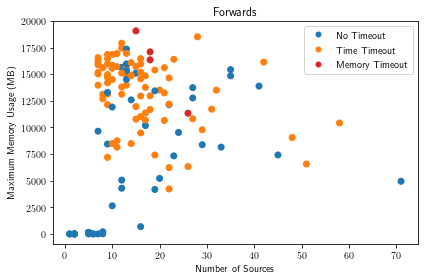

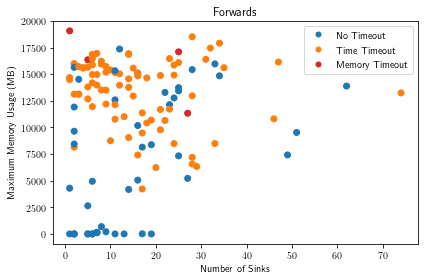

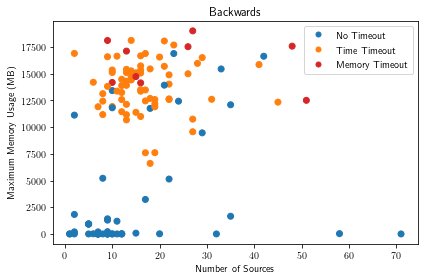

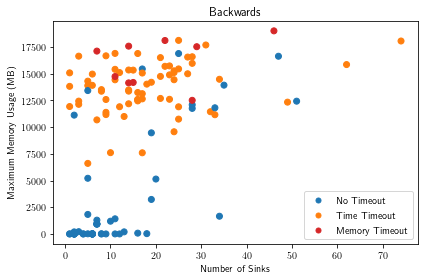

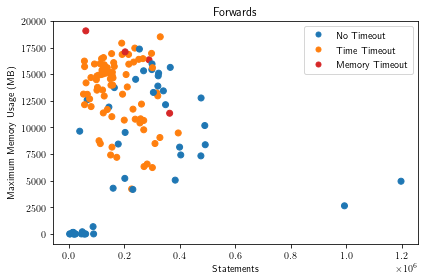

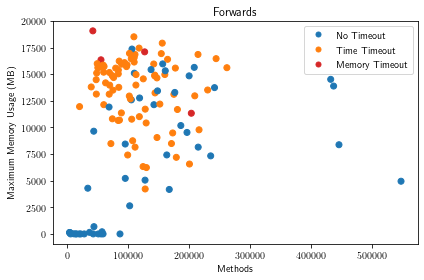

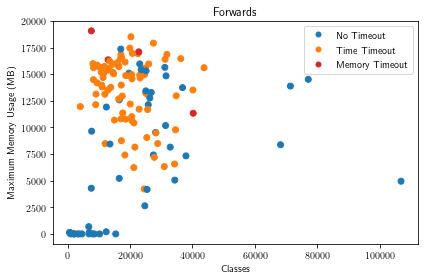

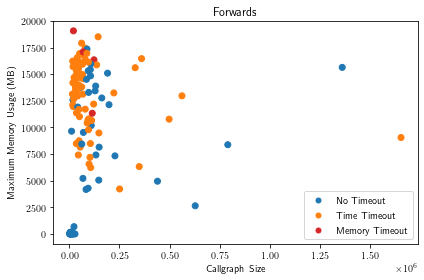

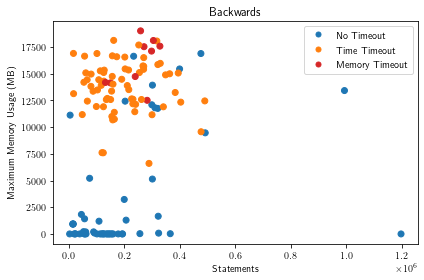

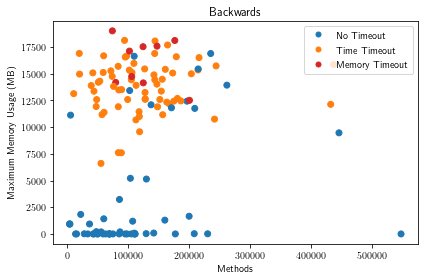

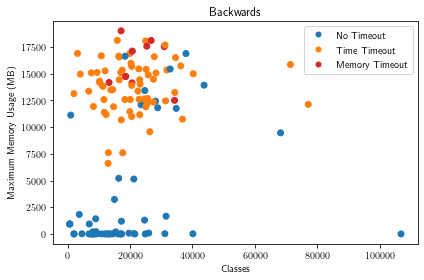

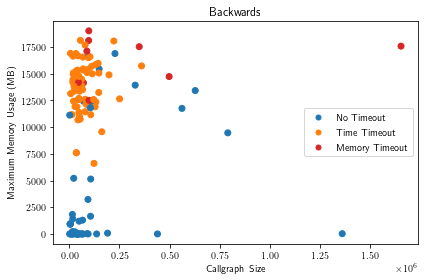

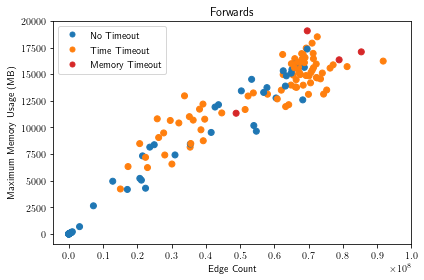

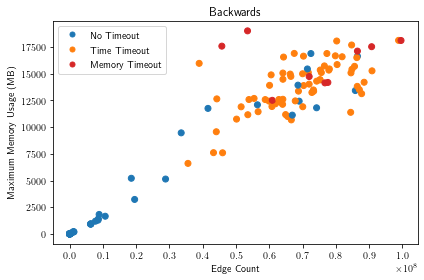

In [27]:
# Per Sources/Sinks
blue_dot = mlines.Line2D([], [], color='#1f77b4', marker='.', linestyle='None',
                          markersize=10, label='No Timeout')
orange_dot = mlines.Line2D([], [], color='#ff7f0e', marker='.', linestyle='None',
                          markersize=10, label='Time Timeout')
red_dot = mlines.Line2D([], [], color='#d62728', marker='.', linestyle='None',
                          markersize=10, label='Memory Timeout')
handles = [blue_dot, orange_dot, red_dot]

xsources = []
xsinks = []
xstmts = []
xclasses = []
xmethods = []
xcg = []
xedgesfw = []
xedgesbw = []
datafw = []
cfw = []
databw = []
cbw = []
for name, app in apps.items():
    if not app.isTimeValid():
        continue
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.maxMemPrecise)
            xsources.append(app.sources)
            xsinks.append(app.sinks)
            xstmts.append(app.statements)
            xclasses.append(app.classes)
            xmethods.append(app.methods)
            xcg.append(app.cgsize)
            c = runToColor(run)
            cfw.append(runToColor(run))
            xedgesfw.append(run.absCountInfoflow + run.absCountAlias)
        elif run.direction == Direction.Backwards:
            databw.append(run.maxMemPrecise)
            cbw.append(runToColor(run))
            xedgesbw.append(run.absCountInfoflow + run.absCountAlias)


plt.figure()
plt.scatter(xsources, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-sources.pgf")       
plt.figure()
plt.scatter(xsinks, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-sinks.pgf")

plt.figure()
plt.scatter(xsources, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-sources.pgf")
plt.figure()
plt.scatter(xsinks, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-sinks.pgf")

plt.figure()
plt.scatter(xstmts, datafw, c=cfw)
plt.xlabel("Statements")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-statements.pgf")
plt.figure()
plt.scatter(xmethods, datafw, c=cfw)
plt.xlabel("Methods")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-methods.pgf")
plt.figure()
plt.scatter(xclasses, datafw, c=cfw)
plt.xlabel("Classes")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-classes.pgf")
plt.figure()
plt.scatter(xcg, datafw, c=cfw)
plt.xlabel("Callgraph Size")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-cg.pgf")
plt.figure()
plt.scatter(xstmts, databw, c=cbw)
plt.xlabel("Statements")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-statements.pgf")
plt.figure()
plt.scatter(xmethods, databw, c=cbw)
plt.xlabel("Methods")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-methods.pgf")
plt.figure()
plt.scatter(xclasses, databw, c=cbw)
plt.xlabel("Classes")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-classes.pgf")
plt.figure()
plt.scatter(xcg, databw, c=cbw)
plt.xlabel("Callgraph Size")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-cg.pgf")

edgeMax = np.max(xedgesbw)
scale = np.arange(0, (round(edgeMax/10**7)+1) * 10**7, 10**7)
plt.figure()
plt.scatter(xedgesfw, datafw, c=cfw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Forwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "fw_maxmem-edges.pgf")

plt.figure()
plt.scatter(xedgesbw, databw, c=cbw)
plt.xticks(scale)
plt.xlabel("Edge Count")
plt.ylabel("Maximum Memory Usage (MB)")
plt.title("Backwards")
plt.legend(handles=handles)
plt.tight_layout()
plt.savefig(FIG_PATH + "bw_maxmem-edges.pgf")

